# Interpolation Part 3: Piecewise polynomial interpolation

In the previous notebook we saw that increasing the degree of the polynomial can have a detrimental effect on the approximation where derivatives are growing with order. A solution is to break the interval into smaller subintervals and fit lower degree polynomials in a piecewise fashion, as we saw in the linear interpolation section.

Mathematically a piecewise polynomial approximation is simply multiple versions of what we saw previously, the devil is in the implementation.

We will go back to our original example, given $f(x) = \sin(x)$ on $x\in[0,10]$ with 11 points.

    
## Application

This is a good example where we will practise our *computational thinking* and break the problem up into managable chunks. 
    
First note that we now have the degree of the polynomial, $N_{deg},$ as an additional free parameter. 

We know that we need to have different polynomials in different parts of the domain, so a sensible first step might be to obtain one polynomial somewhere in the domain; this really just amounts to picking a subset of points and using the code from the previous notebook.

Let's start with a cubic, degree 3, polynomial.
    
</font>
 

In [52]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})            # Increase the font size to 14pt


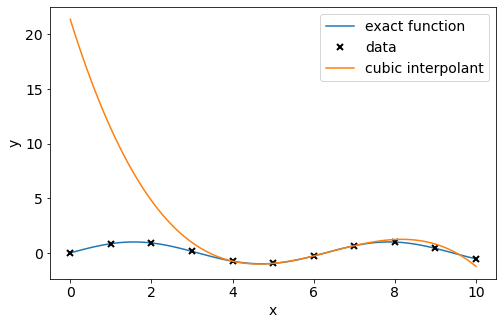

In [53]:
Ndeg = 3 # set the degree 

# Set the knots
M = 11 
x0 = np.linspace(0,10,M)
y0 = np.sin(x0)

# choose the deg+1 points starting at 4

pts = np.arange(4,4+Ndeg+1)

A = np.vander(x0[pts[:]])          # construct the Vandermode matrix
a = np.linalg.solve(A,y0[pts[:]])  # obtain the coefficients by solving the system

pows = (Ndeg-np.arange(Ndeg+1)).reshape(Ndeg+1,1)         # these are the exponents required

# evaluation points
N = 101
x = np.linspace(0.,10.,N)

xnew = np.reshape(x,(1,N))                         # reshape for the broadcast
ynew = np.sum((xnew**pows)*a.reshape(Ndeg+1,1),axis=0) # multiply by coefficients and sum along the right direction

plt.figure(figsize=(8,5))
plt.plot(x,np.sin(x),label='exact function')
plt.plot(x0,y0,'kx',mew=2,label='data')
plt.plot(x,ynew,label='cubic interpolant')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

<font color='#2F4F4F'>
    
Having obtained one interpolant we now need to obtain every interpolant which will be required on our interval. First, notice that the number of interpolants will be $N_{int} = M-N_{deg}$ where $M$ is the number of knots. For each interpolant, $j,$ we will need the set of points $i \in [j,j+N_{deg}+1].$ We can store such sets of points in an $N_{deg}+1 \times N_{int}$ array.
    

In [54]:
Nint = M - Ndeg # We have M-deg interpolants to obtain

pts = np.arange(Ndeg+1) + np.arange(Nint).reshape(Nint,1) # these are the sets of points we require

print(pts)

[[ 0  1  2  3]
 [ 1  2  3  4]
 [ 2  3  4  5]
 [ 3  4  5  6]
 [ 4  5  6  7]
 [ 5  6  7  8]
 [ 6  7  8  9]
 [ 7  8  9 10]]


<font color='#2F4F4F'>

Each row contains the $N_{deg}+1$ points required for each interpolant. 
    
Next, we use these points to obtain the polynomials, or rather the coefficients of the polynomials, themselves. On this occasion we will loop over the $N_{int}$ polynomials as each requires a linear solution. This amounts to the same code to create the Vandermode matrix and solver, but now for each interpolant we use a different set of knots.

In [55]:
a = np.zeros((Ndeg+1,Nint))                   # array of coefficients
for i in range(Nint):                         # loop over interpolants
    A = np.vander(x0[pts[i,:]])               # create Vandermode for this interpolant
    a[:,i] = np.linalg.solve(A,y0[pts[i,:]])  # get the coeffs for this interpolant

<font color='#2F4F4F'>

The final part left to do is decide which interpolant should be used for each of our new data points. The *support* of the interpolants, i.e. the interval created by the knots used to obtain them, are overlapping so we have some choice to make. As we have seen, the interpolants are typically most accurate at the centre of their support so it makes sense to use the interpolant for which the required data point is most central. There are a few ways to obtain this, what we do below is first find the sub-interval $[x_k,x_{k+1}]$ in which the evaluation point lies. We want the interpolant which has this sub-interval at its centre, this will be 
$$
j = k - \left\lfloor \frac{N_{deg}}{2} \right\rfloor,
$$

except near the edges, i.e. where $k<N_{deg}/2$ when we should choose $j=0$ or $k>M-N_{deg}$ where we should choose $j=N_{int}-1.$ 
    
For simplicity we first tackle the problem on evenly space knots, in such a situation obtaining $k$ is easy, as we have seen $k =  \left \lfloor \frac{x-a}{h} \right \rfloor.$ 

In [56]:
y = np.empty_like(x)        # set up new data points
pows = Ndeg-np.arange(Ndeg+1)   # just repeated from above

h = (x0[-1]-x0[0])/(M-1)    # assumed spacing

k = np.minimum(M-2,((x-x[0])/h).astype(int)) # "minimum" making sure we don't overshoot the last subinterval
   
j = k - Ndeg//2

# account for j<0 or j>Nint-1
j = np.maximum(0,j)
j = np.minimum(j,Nint-1)

y = np.sum(a[:,j[:]]*(x[:]**pows.reshape(Ndeg+1,1)),axis=0) # an array broadcase of the powers gives the appropriate alignment of the elements of a


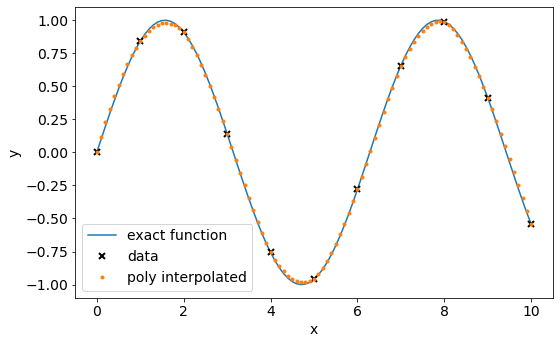

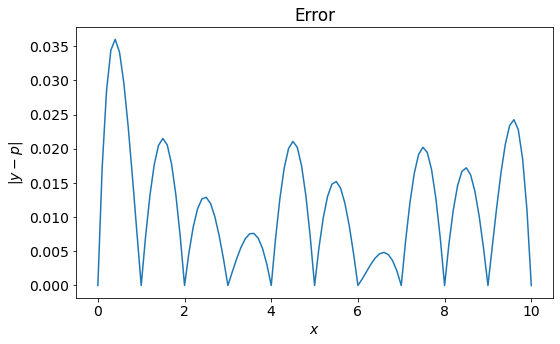

In [57]:
plt.figure(figsize=(8,5))
plt.plot(x,np.sin(x),label='exact function')
plt.plot(x0,y0,'kx',mew=2,label='data')
plt.plot(x,y,'.',label='poly interpolated')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(x,np.abs(np.sin(x)-y))
plt.xlabel('$x$')
plt.ylabel('$|y-p|$')
plt.title('Error')
plt.tight_layout()
plt.show()

**Return to Runge**

Putting this all together we can return to the problem of Runge's phenomenon and see how much difference this makes for 

$$f(x)=\frac{1}{1+25x^2}$$ 

on the interval $x\in[-1,1]$

In [7]:
Ndeg = 3

def f(x):
    return 1./(1+25*x**2)

N = 101
x = np.linspace(-1,1,N)

M = 11
x0 = np.linspace(-1,1,M)
y0 = f(x0)

# First perform the non piecewise interpolation for comparison
#----------------------------------------------------------------
A = np.vander(x0)          # construct the Vandermode matrix
a = np.linalg.solve(A,y0)  # obtain the coefficients by solving the system
pows = (M-1-np.arange(M)).reshape(M,1)         # these are the exponents required
xnew = np.reshape(x,(1,N))                     # reshape for the broadcast
ynew = np.sum((xnew**pows)*a.reshape(M,1),axis=0) # multiply by coefficients and sum along the right direction

# Now do out piecewise polynomial
#----------------------------------------------------------------

Ndeg = 3
h = x0[2]-x0[1]

# We have M-deg interpolants to obtain

Nint = M - Ndeg
pt1 = np.arange(Ndeg+1)
pts = pt1 + np.arange(Nint).reshape(Nint,1) # these are the sets of points we require

a = np.zeros((Ndeg+1,Nint))
for i in range(Nint):
    A = np.vander(x0[pts[i,:]])
    a[:,i] = np.linalg.solve(A,y0[pts[i,:]])

pows = (Ndeg-np.arange(Ndeg+1))
y = np.empty_like(x)

h = (x0[-1]-x0[0])/(M-1)                  # assumed spacing

k = np.minimum(M-2,((x-x[0])/h).astype(int)) # making sure we don't overshoot the last subinterval
   
j = k - Ndeg//2    

# account for j<0 or j>Nint-1, i.e. at the edge
j = np.maximum(0,j)
j = np.minimum(j,Nint-1)

y = np.sum(a[:,j[:]]*(x[:]**pows.reshape(Ndeg+1,1)),axis=0) # an array broadcase of the powers gives the appropriate alignment of the elements of a


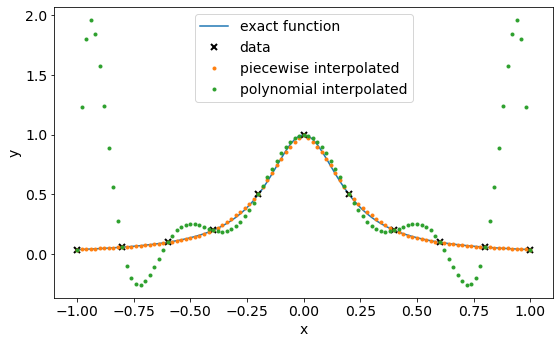

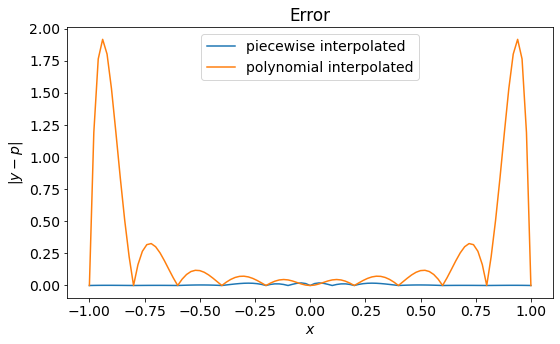

In [10]:
plt.figure(figsize=(8,5))
plt.plot(x,f(x),label='exact function')
plt.plot(x0,y0,'kx',mew=2,label='data')
plt.plot(x,y,'.',label='piecewise interpolated')
plt.plot(x,ynew,'.',label='polynomial interpolated')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(x,np.abs(f(x)-y),label='piecewise interpolated')
plt.plot(x,np.abs(f(x)-ynew),label='polynomial interpolated')
plt.xlabel('$x$')
plt.ylabel('$|y-p|$')
plt.title('Error')
plt.legend()
plt.tight_layout()
plt.show()

<font color='#2F4F4F'>

------

## Aside: uneven data points.
    
If the knots are not evenly spaced we cannot find the subinterval of interest by a simple computation but instead we need to check by conditions. In the example below this is achieved by cycling through each point and finding where in the grid each one lies using `np.where`.

In [9]:
y = np.empty_like(x)     # set up new data points
pows = Ndeg-np.arange(Ndeg+1)

for i in range(N):       # loop over new evaluation points

    if((x[i]<x0).all()): # if we're outside of the interval, set k to extrapolate
        k = 0
    elif((x[i]>x0).all()):
        k = M-1
    else:                # find k for x_i, accounting for the possibility that x_i=x_k
        k = np.where(((x[i]<x0[1:]) & (x[i]>=x0[:-1])) | 
                     ((x0[1:]==x[i]) & (x[i]>x0[:-1])))[0][0]

    # k is the left hand data point of our current subinterval; 
    # we need the polynomial with this point as the *centre*
    
    j = k - Ndeg//2    

    # account for j<0 or j>Nint-1, i.e. at the edge
    j = max(0,j)
    j = min(j,Nint-1)
    
    y[i] = np.sum(a[:,j]*x[i]**pows)  # obtain new data point
    